In [ ]:
"""
Purpose: To tune the hyperparameters
For the checks on whether a mesh is a possible soma
Tests:
1) Side length ratio test
2) Volume test
"""

In [5]:
import trimesh
import numpy as np
from meshlab import Decimator, Poisson
from pathlib import Path

In [33]:
"""
Checking the new validation checks
"""
def side_length_ratios(current_mesh):
    """
    Will compute the ratios of the bounding box sides
    To be later used to see if there is skewness
    """

    # bbox = current_mesh.bounding_box_oriented.vertices
    bbox = current_mesh.bounding_box_oriented.vertices
    x_axis_unique = np.unique(bbox[:,0])
    y_axis_unique = np.unique(bbox[:,1])
    z_axis_unique = np.unique(bbox[:,2])
    x_length = (np.max(x_axis_unique) - np.min(x_axis_unique)).astype("float")
    y_length = (np.max(y_axis_unique) - np.min(y_axis_unique)).astype("float")
    z_length = (np.max(z_axis_unique) - np.min(z_axis_unique)).astype("float")
    #print(x_length,y_length,z_length)
    #compute the ratios:
    xy_ratio = float(x_length/y_length)
    xz_ratio = float(x_length/z_length)
    yz_ratio = float(y_length/z_length)
    side_ratios = [xy_ratio,xz_ratio,yz_ratio]
    flipped_side_ratios = []
    for z in side_ratios:
        if z < 1:
            flipped_side_ratios.append(1/z)
        else:
            flipped_side_ratios.append(z)
    return flipped_side_ratios

def side_length_check(current_mesh,side_length_ratio_threshold=5):
    side_length_ratio_names = ["xy","xz","yz"]
    side_ratios = side_length_ratios(current_mesh)
    pass_threshold = [(k <= side_length_ratio_threshold) and
                      (k >= 1/side_length_ratio_threshold) for k in side_ratios]
    for i,(rt,truth) in enumerate(zip(side_ratios,pass_threshold)):
        if not truth:
            print(f"{side_length_ratio_names[i]} = {rt} ratio was beyong {side_length_ratio_threshold} multiplier")

    if False in pass_threshold:
        return False
    else:
        return True
# current_Pmesh = trimesh.load_mesh("./12346/12346_poisson_soma.off")
# print(side_length_ratios(current_mesh))
# side_length_check(current_mesh,side_length_ratio_threshold=1.55)



In [23]:
def largest_mesh_piece(msh):
    mesh_splits_inner = msh.split(only_watertight=False)
    total_mesh_split_lengths_inner = [len(k.faces) for k in mesh_splits_inner]
    ordered_mesh_splits_inner = mesh_splits_inner[np.flip(np.argsort(total_mesh_split_lengths_inner))]
    return ordered_mesh_splits_inner[0]

In [67]:
def soma_volume_ratio(current_mesh):
    """
    bounding_box_oriented: rotates the box to be less volume
    bounding_box : does not rotate the box and makes it axis aligned
    
    ** checks to see if closed mesh and if not then make closed **
    """
    poisson_temp_folder = Path.cwd() / "Poisson_temp"
    poisson_temp_folder.mkdir(parents=True,exist_ok=True)
    Poisson_obj = Poisson(poisson_temp_folder,overwrite=True)
    
    #get the largest piece
    lrg_mesh = largest_mesh_piece(current_mesh)
    if not lrg_mesh.is_watertight:
        print("Using Poisson Surface Reconstruction to make mesh watertight")
        #run the Poisson Surface reconstruction and get the largest piece
        new_mesh_inner,poisson_file_obj = Poisson_obj(vertices=lrg_mesh.vertices,
               faces=lrg_mesh.faces,
               return_mesh=True,
               delete_temp_files=True)
        lrg_mesh = largest_mesh_piece(new_mesh_inner)

    #turn the mesh into a closed mesh based on 
    
    ratio_val = lrg_mesh.bounding_box.volume/lrg_mesh.volume
#     if ratio_val < 1:
#         raise Exception("Less than 1 value in volume ratio computation")
    return ratio_val

def soma_volume_check(current_mesh,multiplier):
    ratio_val= soma_volume_ratio(current_mesh)
    print("Inside sphere validater: ratio_val = " + str(ratio_val))
    if np.abs(ratio_val) > multiplier:
        return False
    return True

# Getting all of the Somas from previous runs

In [47]:
soma_path = Path("/notebooks/Platinum_Soma/somas_to_test")
soma_files = [x for x in soma_path.glob('**/*')]
soma_meshes = [trimesh.load_mesh(str(x)) for x in soma_path.glob('**/*') if x.is_file()]
soma_meshes

[<trimesh.Trimesh(vertices.shape=(2281, 3), faces.shape=(4500, 3))>,
 <trimesh.Trimesh(vertices.shape=(2854, 3), faces.shape=(5542, 3))>,
 <trimesh.Trimesh(vertices.shape=(2232, 3), faces.shape=(4393, 3))>,
 <trimesh.Trimesh(vertices.shape=(1616, 3), faces.shape=(3165, 3))>,
 <trimesh.Trimesh(vertices.shape=(896, 3), faces.shape=(1734, 3))>,
 <trimesh.Trimesh(vertices.shape=(1179, 3), faces.shape=(2322, 3))>,
 <trimesh.Trimesh(vertices.shape=(1448, 3), faces.shape=(2862, 3))>,
 <trimesh.Trimesh(vertices.shape=(1116, 3), faces.shape=(2174, 3))>,
 <trimesh.Trimesh(vertices.shape=(1463, 3), faces.shape=(2894, 3))>,
 <trimesh.Trimesh(vertices.shape=(1920, 3), faces.shape=(3795, 3))>,
 <trimesh.Trimesh(vertices.shape=(2281, 3), faces.shape=(4383, 3))>,
 <trimesh.Trimesh(vertices.shape=(3108, 3), faces.shape=(6178, 3))>,
 <trimesh.Trimesh(vertices.shape=(2668, 3), faces.shape=(5271, 3))>,
 <trimesh.Trimesh(vertices.shape=(1221, 3), faces.shape=(2411, 3))>,
 <trimesh.Trimesh(vertices.shape=(1

In [34]:
mesh_side_length_ratios = [side_length_ratios(s) for s in soma_meshes]

In [68]:
mesh_volume_checks = [soma_volume_ratio(s) for s in soma_meshes]  

Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls
removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebo

face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls
removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebo

face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls
removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off
Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebo

face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off


# Visualize the Results

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
np.array(mesh_side_length_ratios).ravel()

(array([87., 42., 18.,  3.,  4.,  1.,  0.,  0.,  0.,  1.]),
 array([1.00040052, 1.14166242, 1.28292433, 1.42418624, 1.56544815,
        1.70671006, 1.84797197, 1.98923388, 2.13049578, 2.27175769,
        2.4130196 ]),
 <a list of 10 Patch objects>)

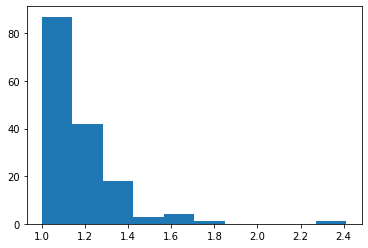

In [40]:
soma_lengths_unraveled = np.array(mesh_side_length_ratios).ravel()
plt.hist(soma_lengths_unraveled)

In [62]:
cutoff_value = 1.7
file_index = np.array(np.where(soma_lengths_unraveled > cutoff_value)[0])/3
file_index = file_index.astype("int")
file_index
files_of_interest = np.array(soma_files)[file_index]
files_of_interest

array([PosixPath('/notebooks/Platinum_Soma/somas_to_test/110361692999153798_soma_0.off'),
       PosixPath('/notebooks/Platinum_Soma/somas_to_test/91208269699305759_soma_5.off')],
      dtype=object)

In [63]:
chosen_file_index = 0
big_mesh = trimesh.load_mesh(str(files_of_interest[chosen_file_index]))
big_mesh.show()

# - Checking the mesh volume checks

(array([26., 25.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.32609866e-02, 2.75240029e+00, 5.48153960e+00, 8.21067891e+00,
        1.09398182e+01, 1.36689575e+01, 1.63980968e+01, 1.91272361e+01,
        2.18563754e+01, 2.45855148e+01, 2.73146541e+01]),
 <a list of 10 Patch objects>)

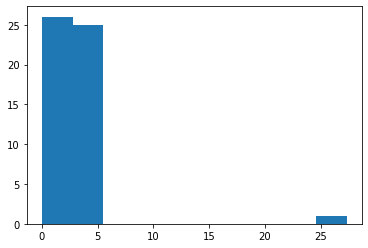

In [70]:
mesh_volume_checks
plt.hist(mesh_volume_checks)

In [86]:
#mesh_volume_checks.remove(mesh_volume_checks[49])

(array([ 1.,  0.,  0.,  0., 11., 20., 12.,  6.,  0.,  1.]),
 array([0.02326099, 0.50626704, 0.98927309, 1.47227914, 1.95528518,
        2.43829123, 2.92129728, 3.40430333, 3.88730938, 4.37031543,
        4.85332148]),
 <a list of 10 Patch objects>)

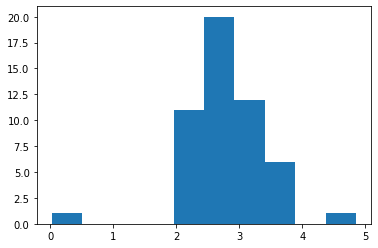

In [88]:
plt.hist(mesh_volume_checks)

In [96]:
cutoff_value = 3.8
file_index = np.array(np.where(np.array(mesh_volume_checks) < 1)[0])
file_index = file_index.astype("int")
file_index
files_of_interest = np.array(soma_files)[file_index]
files_of_interest

array([PosixPath('/notebooks/Platinum_Soma/somas_to_test/90231147459666747_soma_1.off')],
      dtype=object)

In [97]:
file_index

array([4])

In [98]:
chosen_file_index = 0
big_mesh = trimesh.load_mesh(str(files_of_interest[chosen_file_index]))
big_mesh.show()

In [99]:
poisson_temp_folder = Path.cwd() / "Poisson_temp"
poisson_temp_folder.mkdir(parents=True,exist_ok=True)
Poisson_obj = Poisson(poisson_temp_folder,overwrite=True)

#get the largest piece
lrg_mesh = largest_mesh_piece(big_mesh)

print("Using Poisson Surface Reconstruction to make mesh watertight")
#run the Poisson Surface reconstruction and get the largest piece
new_mesh_inner,poisson_file_obj = Poisson_obj(vertices=lrg_mesh.vertices,
       faces=lrg_mesh.faces,
       return_mesh=True,
       delete_temp_files=True)
lrg_mesh = largest_mesh_piece(new_mesh_inner)
lrg_mesh.show()

Using Poisson Surface Reconstruction to make mesh watertight
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
xvfb-run -a -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off -o /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off -s /notebooks/Platinum_Soma/poisson.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!


removed temporary input file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None.off
removed temporary output file: /notebooks/Platinum_Soma/Poisson_temp/neuron_None_poisson.off


# Finding a good value for maximum of soma sizes

(array([ 8.,  5.,  9., 12.,  6.,  2.,  6.,  1.,  0.,  3.]),
 array([1478. , 2074.8, 2671.6, 3268.4, 3865.2, 4462. , 5058.8, 5655.6,
        6252.4, 6849.2, 7446. ]),
 <a list of 10 Patch objects>)

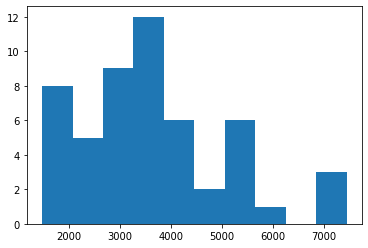

In [101]:
face_count_somas = [len(k.faces) for k in soma_meshes]
plt.hist(face_count_somas)